# 📌 Intro.
- 그동안 배운 딥러닝개념 및 실습의 내용을 활용해 총 3개의 프로젝트를 진행합니다.
    - Boston 주택 가격 예측 모델 : 주택 가격을 예측하는 회귀(Regression)모델 by 딥러닝
    - Reuters 딥러닝 모델 : Reuters의 뉴스기사/금융정보 데이터를 분류하는 모델
    - CIFAR10 딥러닝 모델 : 다양한 동물(10개클래스) 데이터를 분류하는 모델

---

- 이중 세번째 프로젝트인 CIFAR10 데이터 셋으로 10종의 동물을 분류하는 모델을 만들어 봅니다.

In [1]:
# GPU 세팅
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)
        
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

Num GPUs Available:  1


## 데이터 불러오기 및 전처리

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10

In [3]:
# CIFAR-10 데이터셋을 로드
from tensorflow.keras.datasets import cifar10
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# 훈련 데이터와 검증 데이터를 분리
# 여기서는 20%를 검증 데이터로 사용
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

# 각 데이터셋과 레이블의 크기를 출력
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


- class_name 변수를 만들어 cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'를 담습니다.

In [4]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### 데이터 형태 확인

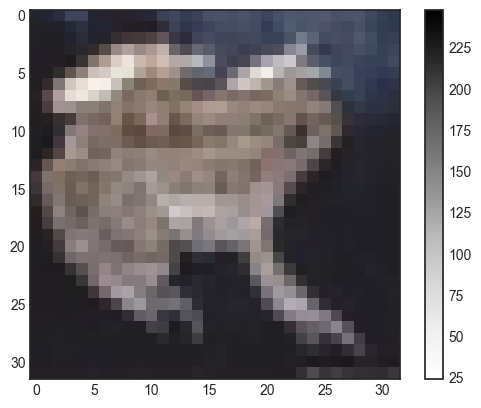

In [5]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [6]:
# 훈련 데이터, 검증 데이터, 테스트 데이터의 형태(shape)를 출력
print("훈련 데이터 형태:", x_train.shape)
print("검증 데이터 형태:", x_val.shape)
print("테스트 데이터 형태:", x_test.shape)

훈련 데이터 형태: (40000, 32, 32, 3)
검증 데이터 형태: (10000, 32, 32, 3)
테스트 데이터 형태: (10000, 32, 32, 3)


### 데이터 형태 변환

In [7]:
# 데이터의 형태를 32 * 32 * 3 = 3072로 변형
x_train = x_train.reshape((-1, 32 * 32 * 3))
x_val = x_val.reshape((-1, 32 * 32 * 3))
x_test = x_test.reshape((-1, 32 * 32 * 3))

# 변형된 데이터의 형태(shape)를 출력
print("훈련 데이터 형태:", x_train.shape)
print("검증 데이터 형태:", x_val.shape)
print("테스트 데이터 형태:", x_test.shape)

훈련 데이터 형태: (40000, 3072)
검증 데이터 형태: (10000, 3072)
테스트 데이터 형태: (10000, 3072)


### 데이터 정규화

In [8]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 모델 구성 및 컴파일

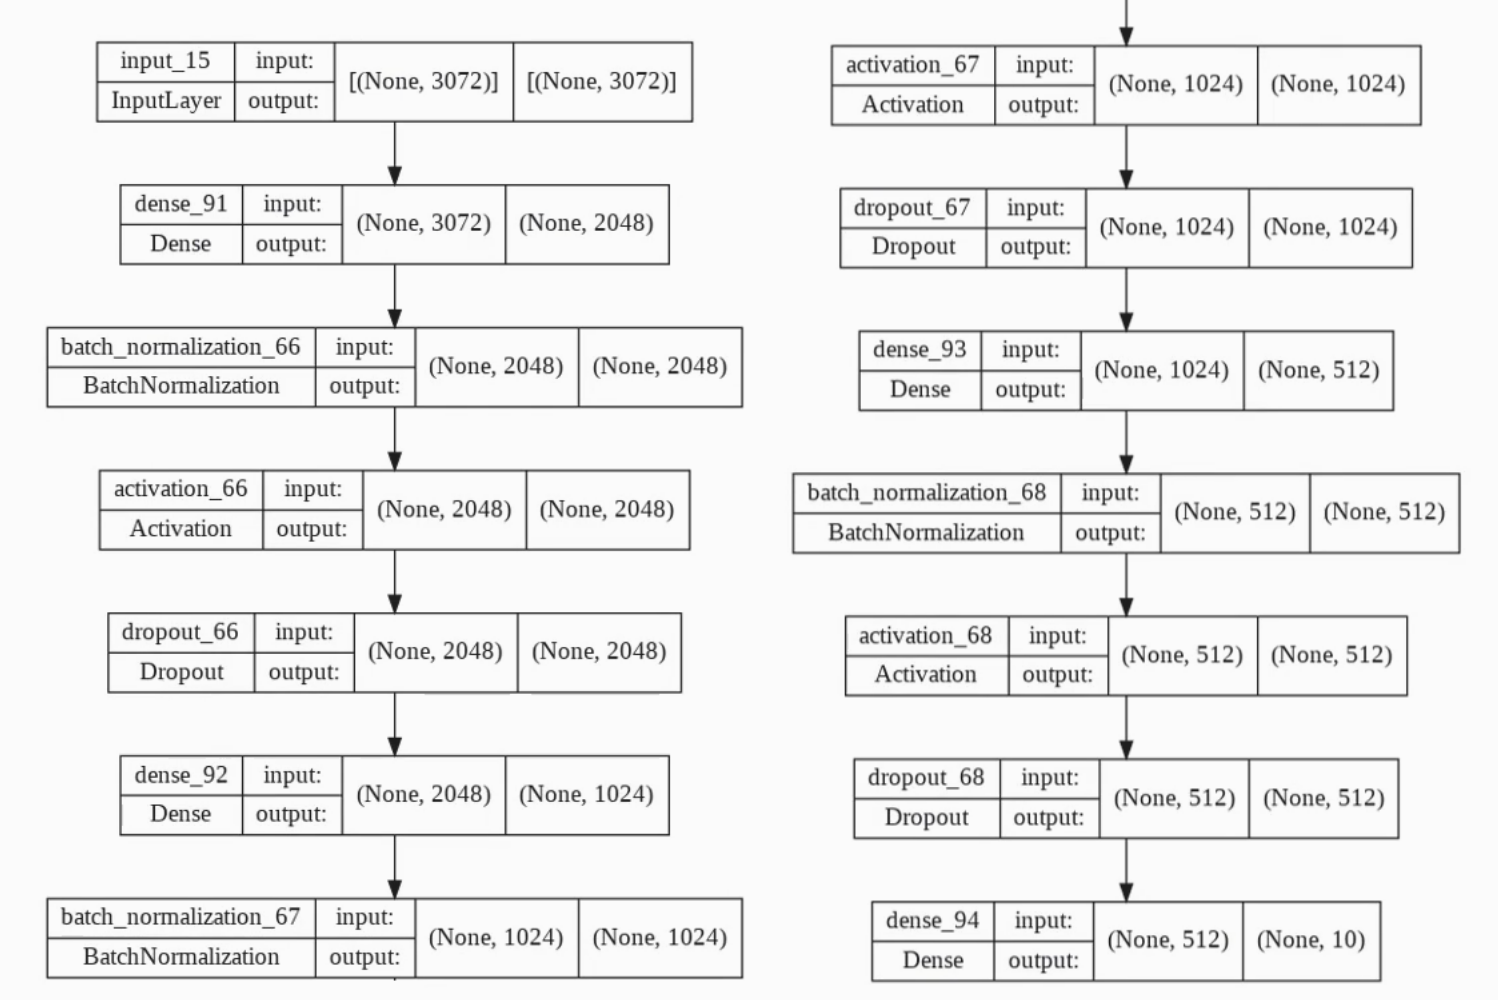

- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 10개의 이미지를 분류하는 딥러닝 모델을 구성합니다.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# Sequential 모델 생성
model = Sequential()

# 첫 번째 은닉층, 입력 차원은 3072
model.add(Dense(2048, input_shape=(3072,)))

# BatchNormalization 레이어 추가. 입력 데이터를 정규화
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어 추가
model.add(Activation('relu'))

# Dropout 레이어 추가. 50%의 뉴런을 랜덤하게 비활성화
model.add(Dropout(0.5))

# 두 번째 은닉층
model.add(Dense(1024))

# BatchNormalization 레이어 추가
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어 추가
model.add(Activation('relu'))

# Dropout 레이어 추가. 50%의 뉴런을 랜덤하게 비활성화
model.add(Dropout(0.5))

# 세 번째 은닉층
model.add(Dense(512))

# BatchNormalization 레이어 추가
model.add(BatchNormalization())

# 활성화 함수로 'relu'를 사용하는 레이어 추가
model.add(Activation('relu'))

# Dropout 레이어 추가. 50%의 뉴런을 랜덤하게 비활성화
model.add(Dropout(0.5))

# 출력층. 클래스 수가 10개이므로 'softmax' 활성화 함수 사용
model.add(Dense(10, activation='softmax'))

# 모델 컴파일. 'categorical_crossentropy' 손실 함수와 Adam 옵티마이저 사용
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0

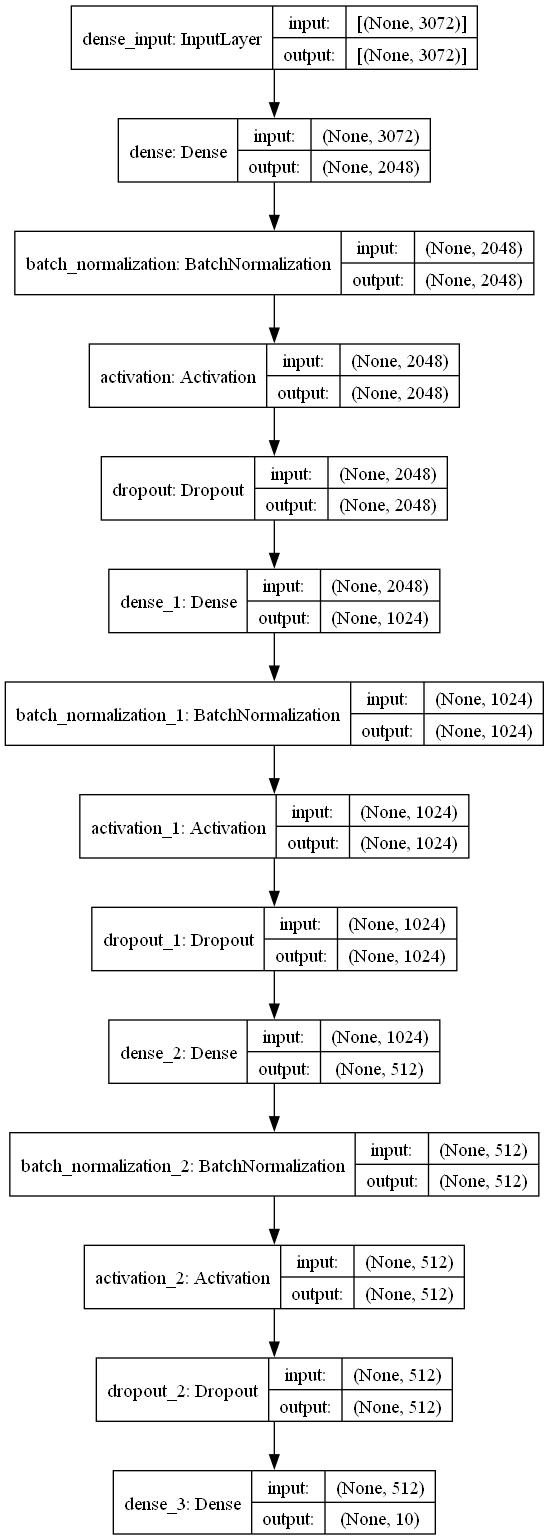

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 모델 학습

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint 설정: 가장 좋은 모델을 저장
checkpoint = ModelCheckpoint('baseline_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# EarlyStopping 설정: 5 에포크 동안 val_loss 개선이 없으면 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    epochs=50, 
                    validation_data=(x_test, y_test), 
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

Epoch 1/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9635 - accuracy: 0.3209 - val_loss: 1.9490 - val_accuracy: 0.3207
Epoch 2/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6650 - accuracy: 0.4053 - val_loss: 1.5951 - val_accuracy: 0.4276
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.5912 - accuracy: 0.4331 - val_loss: 1.5692 - val_accuracy: 0.4441
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5414 - accuracy: 0.4493 - val_loss: 1.5722 - val_accuracy: 0.4342
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4974 - accuracy: 0.4678 - val_loss: 1.6257 - val_accuracy: 0.4212
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4621 - accuracy: 0.4799 - val_loss: 1.4012 - val_accuracy: 0.5016
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 1.4309 - accuracy: 0.4891 - val_loss: 1.4986 - val_accuracy:

### 학습결과 시각화

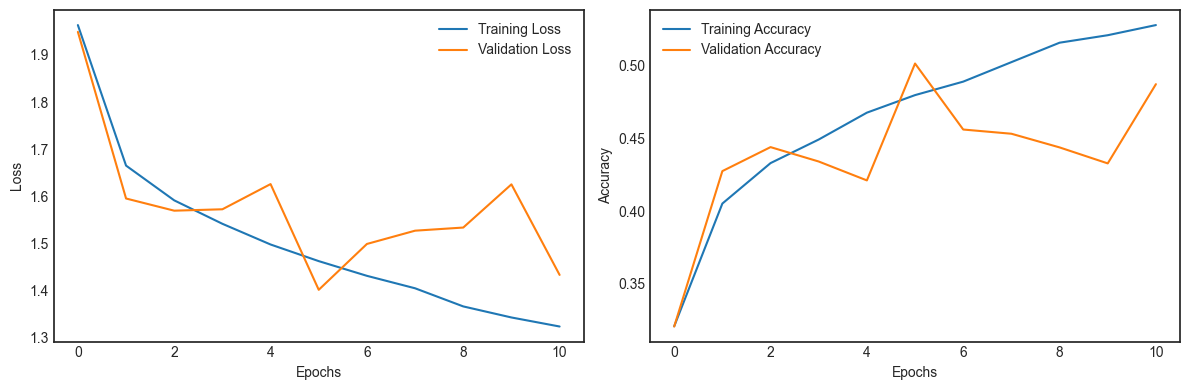

In [12]:
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 정확도와 검증 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 학습 결과 확인(테스트)

In [13]:
import seaborn as sns

# 모델별로 테스트 결과를 가로 막대 그래프로 시각화하고, 막대 가운데에 수치를 표시하는 함수 (Seaborn 사용)
def plot_test_results(test_results):
    # 테스트 손실과 정확도를 분리하여 DataFrame으로 변환
    import pandas as pd
    data = []
    for model, metrics in test_results.items():
        data.append({'Model': model, 'Metric': 'Loss', 'Value': metrics['test_loss']})
        data.append({'Model': model, 'Metric': 'Accuracy', 'Value': metrics['test_accuracy']})
    df = pd.DataFrame(data)

    # 데이터 개수에 따라 그래프 크기 조절
    fig_height = max(4, 0.6 * len(df['Model'].unique()))

    # Seaborn 스타일 설정
    sns.set(style="whitegrid")

    # 가로 막대 그래프 그리기
    plt.figure(figsize=(12, fig_height))
    g = sns.barplot(x="Value", y="Model", hue="Metric", data=df, palette="muted")

    # 막대 가운데에 수치 표시
    for p in g.patches:
        width = p.get_width()
        plt.text(width / 2, p.get_y() + p.get_height() / 2,
                 f'{width:.4f}',
                 ha='center', va='center')

    plt.xlabel('Value')
    plt.title('Test Metrics per Model')
    plt.legend(loc='upper right')  # 범례 위치 변경
    plt.tight_layout()
    plt.show()

In [14]:
# 모델 평가 결과를 저장하고 업데이트하는 함수
def update_test_results(model_name, test_loss, test_accuracy, test_results=None):
    """
    주어진 모델 이름, 테스트 손실, 테스트 정확도를 받아서
    test_results 딕셔너리에 추가하거나 업데이트
    test_results 딕셔너리가 제공되지 않으면 직접 생성

    :param model_name: 모델의 이름 (string)
    :param test_loss: 모델의 테스트 손실 (float)
    :param test_accuracy: 모델의 테스트 정확도 (float)
    :param test_results: 모델 평가 결과를 저장하는 딕셔너리 (dict)
    :return: 업데이트된 test_results 딕셔너리
    """
    if test_results is None:
        test_results = {}
    test_results[model_name] = {'test_loss': test_loss, 'test_accuracy': test_accuracy}
    return test_results

In [15]:
from tensorflow.keras.models import load_model

# 가장 좋은 모델을 불러오기
best_model = load_model('baseline_model.h5')

# 불러온 모델로 테스트 데이터를 평가
test_loss, test_accuracy = best_model.evaluate(x_test, y_test)

test_results = update_test_results('baseline_model', test_loss, test_accuracy)

print(f'테스트 손실: {test_loss:.4f}')
print(f'테스트 정확도: {test_accuracy:.4f}')

313/313 [==============================] - 1s 2ms/step - loss: 1.4012 - accuracy: 0.5016
테스트 손실: 1.4012
테스트 정확도: 0.5016
